In [1]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from tqdm import tqdm
import sys
import os
import matplotlib.pyplot as plt
import csv
import time
from IPython.display import HTML
from IPython.display import display
import seaborn as sns

%matplotlib inline

# Machine Translation Lab 2:  Neural Language Modeling

In this lab, we will train recurrent neural network character level language models. We will be experimenting with model architecture and we'll try modeling two different languages. The task of a language model is to predict the next token, given the history of observed tokens. We will be evaluating our models directly against this objective by measuring perplexity. We will also use the models to generate new text so that we can jusge how well ware the characteristics of the languages and the particular datasets captured.


*Lab developed by: Ida Szubert, Sameer Bansal, Adam Lopez*

## Chainer

The neural network framework we'll be using is Chainer. If you're stuck with the tasks in this lab, these resources might help you:

* Try and work through the basic [chainer tutorial](http://docs.chainer.org/en/stable/tutorial/basic.html). You can skip *advanced* chainer concepts such as the [trainer class](http://docs.chainer.org/en/stable/tutorial/basic.html#trainer)

* Have a look at the multi-layer feedforward neural network [example on MNIST dataset](http://docs.chainer.org/en/stable/tutorial/basic.html#example-multi-layer-perceptron-on-mnist). The code for ```class MLP(Chain)``` definition shows how we can add [layers](http://docs.chainer.org/en/stable/reference/links.html#learnable-connections) (linear in this example, other choices include LTSM, GRU) and [activation functions](http://docs.chainer.org/en/stable/reference/functions.html#activation-functions) (RELU in this example, other choices include sigmoid, tanh ) in Chainer.

### Background material
This lab is based on text and code from several online resources. It is highly recommended to check out the following:
- A great explanation and visualization of recurrent neural networks: [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
- [numpy based code to train a character-level language model](https://gist.github.com/karpathy/d4dee566867f8291f086)
- [Chainer implementation of the above source code](https://github.com/yusuketomoto/chainer-char-rnn)
- [Chainer reference](http://docs.chainer.org/en/stable/reference/)
- [Really cool explanation of LSTM (and GRU)](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

---
## Datasets
---
We will be using two datasets:
* English: collection of all William Shakespeare's work, *tinyshakespeare* (created by Andrej Karpathy: https://github.com/karpathy/char-rnn/tree/master/data/tinyshakespeare) 
* Polish: the epic poem *Pan Tadeusz* by Adam Mickiewicz

The input files can be found in the ```data/``` directory.

Let's look at the first few lines:

In [2]:
print("------------- Shakespeare -------------")
!head -n 20 data/tinyshakespeare.txt
print("---------------------------------------")
print("\n------------- Polish -------------")
!head -n 20 data/mickiewicz.txt
print("---------------------------------------")

------------- Shakespeare -------------
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
---------------------------------------

------------- Polish -------------
Adam Mickiewicz

Pan Tadeusz czyli ostatni zajazd na Litwie






Księga pierwsza



Gospodarstwo

Powrót panicza — Spotkanie się pierwsze w pokoiku, drugie u stołu — Ważna Sędziego nauka o grzeczności — Podkomorzego uwagi polityczne nad modami — Początek sporu o Kusego i Sokoła — Żale Wojskiego — Ostatni Woźny Trybunału — Rzut oka na ówczesny stan polityczny Litwy i Europy

    Litwo! Ojczyzno moja! ty jesteś jak zdrowie:
Ile cię trzeba cenić, ten tylko się dowie,
Kto cię stracił. Dziś piękność twą w całej ozdobie
--------------

You will notice that both texts are **structured**. In case of Shakespeare's plays there are speaker tags, and new line characters after each dialog. In *Pan Tadeusz* the structure is less obvious, but more rigid, as each line (excluding chapter titles and chapter synopsis) is composed of exactly thirteen syllables. 

We do not perform any text preprocessing. That means that stopwords are not removed, capital letters are not converted to lower case and punctuation is left intact.

As our models will be **predicting characters**, let's explore the number of unique characters and their frequencies.

In [3]:
# define the training file location
English = True

if English:
    train_fname = os.path.join("data", "tinyshakespeare.txt")
    data_postfix = "shakespeare"
else:
    train_fname = os.path.join("data", "mickiewicz.txt")
    data_postfix = "tadeusz"

In [4]:
def read_input_txt(fname):
    # define a dictionary. Each unique character will be a key in the dictionary
    # and the value will be its count
    chars = {}
    with open(fname, "r") as f:
        # read entire file content into buffer
        data = f.read()
    # count occurrences of each character
    for c in data:
        if c not in chars:
            chars[c] = 1
        else:
            chars[c] += 1
    return data, chars

In [5]:
data, chars = read_input_txt(train_fname)
vocab_size = len(chars.keys())
data_size = len(data)

# 90%-10% split for test and validation data
train_data = data[: data_size * 90 // 100]
dev_data = data[data_size * 90 // 100 :]
train_size = len(train_data)
dev_size = len(dev_data)

if English:
    print("-------- English corpus --------")
else:
    print("-------- Polish corpus --------")
print("\n{0:^30}".format("data stats"))
print("{0:^30}".format("-" * len("data stats")))
print("{0:>20s} | {1:10d}".format("total characters", data_size))
print("{0:>20s} | {1:10d}".format("total unique chars", len(chars.keys())))
print("{0:>20s} | {1:10d}".format("train characters", train_size))
print("{0:>20s} | {1:10d}".format("test characters", dev_size))

# printing top 5 characters based on frequency

print("\n{0:^30}".format("top 5 characters in data"))
print("{0:^30}".format("-" * len("top 5 characters in data")))
print("{0:>20s} | {1:>10s}".format("char", "freq"))
out_rows = [(k, v) for k, v in sorted(list(chars.items()), reverse=True, key=lambda t:t[1])[:5]]
for k, v in out_rows:
    print("{0:>20s} | {1:>10d}".format(k, v))

-------- English corpus --------

          data stats          
          ----------          
    total characters |    1115394
  total unique chars |         65
    train characters |    1003854
     test characters |     111540

   top 5 characters in data   
   ------------------------   
                char |       freq
                     |     169892
                   e |      94611
                   t |      67009
                   o |      65798
                   a |      55507


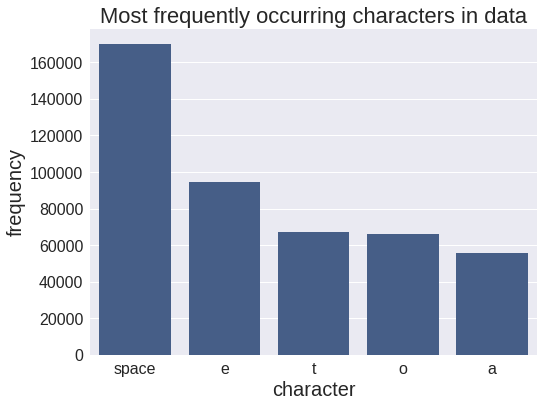

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches(8,6)

# data to plot
c_top, f_top = zip(*out_rows)
c_top = ["space" if c == " " else c for c in c_top]

sns.barplot(x=c_top, y=f_top, palette=[sns.xkcd_rgb["denim blue"]]*len(f_top))
ax.set_xlabel("character", size=20)
ax.set_ylabel("frequency", size=20)
for t in ax.get_xticklabels():
    t.set_size(16)
for t in ax.get_yticklabels():
    t.set_size(16)
    
plt.title("Most frequently occurring characters in data", size=22)

### Encoding data

The minimal pre-processing of the dataset which we perform involves mapping each character to a unique integer id. It is done for the purposes of efficiency, as numerical ids are easier to manipulate than string ids.

In [7]:
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

In [8]:
# prepare an integer representation of the dataset
data_char_to_ids = []
for c in data:
    data_char_to_ids.append(char_to_ix[c])
print("****original text excerpt**** \n{0:s}".format(data[:50]))
print("****text converted to integer representation**** \n{0:s}".format(" ".join(map(str, 
                                                                       data_char_to_ids[:50]))))

****original text excerpt**** 
First Citizen:
Before we proceed any further, hear
****text converted to integer representation**** 
0 1 2 3 4 5 6 1 4 1 7 8 9 10 11 12 8 13 14 2 8 5 15 8 5 16 2 14 17 8 8 18 5 19 9 20 5 13 21 2 4 22 8 2 23 5 22 8 19 2


------
## Models
------
All our models will use the RNN base class, which is defined here. When you'll be asked to implement some changes to the model architecture, you should modify this class. It specifies how many layer will the network have, what their sizes will be, what sort of cells will be used and what is the loss function.

Chainer reference can be found at: http://docs.chainer.org/en/stable/reference/

In [12]:
class RNN(Chain):
    # constructor
    # vocab_size: indicates the number of unique characters in the vocabulary
    # n_units: size of the hidden layer
    # gpu_id: if >=0, use GPU, else CPU
    def __init__(self, vocab_size, n_units, gpu_id, use_LSTM=True):
        # initialise Chainer base class
        super(RNN, self).__init__()
        #---------------------------------------------------------
        # construct Neural Network
        #---------------------------------------------------------
        # add embedding layer
        # http://docs.chainer.org/en/stable/reference/links.html#embedid
        #---------------------------------------------------------
        self.add_link("embed", L.EmbedID(vocab_size, n_units))
        #---------------------------------------------------------
        # add LSTM or GRU layer
        if use_LSTM:
            # http://docs.chainer.org/en/stable/reference/links.html#lstm
            self.add_link("L1", L.LSTM(n_units, n_units))
        else:
            # http://docs.chainer.org/en/stable/reference/links.html#gru
            self.add_link("L1", L.StatefulGRU(n_units, n_units))
        '''
        ------------------------------------------------------------------
        Q3 - ADD CODE (around) HERE
        Go deep, add 1 more LSTM/GRU layer
        ------------------------------------------------------------------
        '''
        if use_LSTM:
            # http://docs.chainer.org/en/stable/reference/links.html#lstm
            self.add_link("L2", L.LSTM(n_units, n_units))
        else:
            # http://docs.chainer.org/en/stable/reference/links.html#gru
            self.add_link("L2", L.StatefulGRU(n_units, n_units))
        #---------------------------------------------------------
        # add output layer
        # http://docs.chainer.org/en/stable/reference/links.html#linear
        self.add_link("out", L.Linear(n_units,vocab_size))
        #---------------------------------------------------------
        
    def reset_state(self):
        # reset LSTM state
        # NOTE: the name field using during add_link call 
        # is used to refer to the layer
        self.L1.reset_state()
        
    # function to compute the forward pass through the network layers
    def forward(self, word):
        # lookup character embedding and compute the hidden state
        h1 = self.L1(self.embed(word))
        # compute the output layer over the hidden state
        out = self.out(h1)
        return out
    
    # function to compute the loss for training
    def __call__(self, c_n1, c_n2):
        # call forward to predict output
        # calculate softmax and then the cross entropy loss
        # Chainer (and most NN frameworks) provide functions to compute 
        # the softmax and cross entropy loss together
        self.loss = F.softmax_cross_entropy(self.forward(c_n1), c_n2)
        # return loss
        return self.loss
    

## Training code

We specify whether traing should be done on CPU or GPU. In this lab we will train on CPUs. If you wish to try GPU training on your own machine, follow GPU-specific Chainer installation instructions as given on the [webpage](http://docs.chainer.org/en/stable/install.html).

In [13]:
# if >= 0, use GPU, if negative use CPU
gpuid = -1

# use cuda if GPU or numpy if CPU
xp = cuda.cupy if gpuid >= 0 else np

There are some paramteres which need to be preset. We specify the optimizer we wish to use and the rate of weight decay.

In [14]:
def setup_model(model):
    #---------------------------------------------------------
    # copy model to GPU if selected
    #---------------------------------------------------------
    if gpuid >= 0:
        cuda.get_device(gpuid).use()
        model.to_gpu()
    #---------------------------------------------------------
    # optimizer
    # Select an optimizer
    # http://docs.chainer.org/en/stable/reference/optimizers.html
    # Alternatives: SGD, AdaGrad, RMSprop, etc
    # We can also add weight decay
    #---------------------------------------------------------
    optimizer = optimizers.Adam()
    # link optimizer to model
    optimizer.setup(model)
    # add weight decay
    optimizer.add_hook(chainer.optimizer.WeightDecay(rate=0.0005))
    
    return optimizer

Using the base class we now define a particular model instance which we'll be training. To start with, we'll define a LSTM model.

In [15]:
#---------------------------------------------------------
# define model
#---------------------------------------------------------
use_LSTM = True
lstm_postfix = "lstm" if use_LSTM else "gru"
model_baseline = RNN(vocab_size, 512, gpuid, use_LSTM=use_LSTM)
# the name field is used for logging stats and storing the model parameters
model_baseline.__dict__['name'] = "baseline_{0:s}_{1:s}".format(data_postfix, lstm_postfix)
'''
------------------------------------------------------------------
Q2 - ADD CODE (around) HERE

A. Define a new model using GRU instead of LSTM
B. Train and compute loss and perplexity as done for model_baseline
C. Compare the performance and training time between the GRU and LSTMs
------------------------------------------------------------------
'''
optimizer_baseline = setup_model(model_baseline)

With a model instance in place, let's now look at how training proceeds for a batch of training examples.

In [16]:
def train_batch(batch_data, model, optimizer):
    # reset LSTM initial state before training each batch
    model.reset_state()
    
    # reset loss
    loss = 0
    
    # for each character in the batch, the target character is the next in sequence
    s, b = batch_data.shape
    # for all sequences in the batch, feed the characters one by one
    for i in range(s-1):
        # pick a character from each sequence
        c1 = Variable(batch_data[i], volatile=False)
        # pick the next character as target
        c2 = Variable(batch_data[i+1], volatile=False)
        loss += model(c1, c2)    
    
    # reset model gradients
    model.cleargrads()
    # compute loss through back prop
    loss.backward()
    # update parameters
    optimizer.update()
    return loss

Finally, in the main train_loop() function we define the whole learning procedure.

In [17]:
def train_loop(model, optimizer, data, n_epochs=3, batch_size=128, seq_len=64, logging=True):
    if logging and model.__dict__['name']:
        train_log_fname = "{0:s}_train.log".format(model.__dict__['name'])
        train_log = open(train_log_fname, "w")
        train_writer = csv.writer(train_log, lineterminator="\n")
        train_writer.writerow(["iter", "loss"])
    
    # compute the number of batches in the data
    data_size = len(data)
    num_batches = data_size // (batch_size * seq_len)
    
    # print reference text excerpt
    print("Reference text:\n{0:s}".format(data[1000:1100]))
    # sample text from the model
    # this is on the untrained model and the output will be random characters
    print("Sampled text:\n{0:s}".format(sample(list(data[1000]), 100, model)[0]))
    
    # start training epochs
    for epoch in range(n_epochs):
        # start progress bar for current epoch
        sys.stderr.flush()
        with tqdm(total=data_size) as pbar:
            sys.stderr.flush()
            for i in range(0, num_batches):
                # loop through the entire data in chunks of batch_size
                # note: using the integer id representation of the text
                start_i = i*(batch_size*seq_len)
                end_i = start_i + (batch_size*seq_len)
                batch_data = xp.array(data_char_to_ids[start_i:end_i], dtype=xp.int32)
                batch_data = batch_data.reshape((batch_size, seq_len))
                # call batch training
                loss = train_batch(batch_data.T, model, optimizer)
                # extract value of loss from Chainer variable returned
                loss = float(loss.data)
                # compute number of characters trained on so far
                it = (epoch * data_size) + i + (batch_size*seq_len)
                # write loss to file
                train_writer.writerow([it, loss])
                '''
                ------------------------------------------------------------------
                Q1 - ADD CODE (around) HERE
                
                A. Compute perplexity and add this information to the train 
                log file
                B. Compute perplixity over validation data and create a new log file
                ------------------------------------------------------------------
                '''
                pbar.set_description("epoch={0:d}, loss={1:.6f}".format(epoch+1, loss))
                pbar.update(batch_size*seq_len)
                # Sample 10 times
        # sample at the end of each epoch
        print("Sampling from starting char={0:s}, {1:d} characters".format(data[1000], 100))
        print("Sampled text:\n{0:s}".format(sample(list(data[1000]), 100, model)[0]))
    
    if train_log:
        train_log.close()
        print("------------------------------------------------")
        print("train log file: {0:s}".format(train_log_fname))
    # Save model
    if model.__dict__['name']:
        serializers.save_npz("{0:s}.npz".format(model.__dict__['name']), model)
        print("------------------------------------------------")
        print("model file: {0:s}".format(model.__dict__['name']))

As you've probably noticed, train_loop() calls a sampling function. Below you can see do we go about using a trained model to generate, rather than predict, novel text.

In [18]:
def sample(s_chars, n_chars, model, sampling=True):
    # Sample n_chars, with starting char: s_char
    sample_text = s_chars[:]
    
    model.reset_state()
    
    # initialize with s_char
    for s_char in s_chars:
        # compute the prediction from the starting character
        c = Variable(xp.asarray([char_to_ix[s_char]], dtype=np.int32), volatile=True)
        out = model.forward(c)

    prob = F.softmax(out)
    
    # Sample remaining characters
    for i in range(n_chars):
        # compute probability distribution over the characters using softmax
        prob = F.softmax(out)
        
        # if gpu, convert into numpy array in order to sample
        if gpuid >= 0:
            prob = cuda.to_cpu(prob.data)[0].astype(np.float64)
        else:
            prob = prob.data[0].astype(np.float64)
        
        # normalize probability
        prob /= np.sum(prob)
        
        if sampling:
            # Sample next character from the predicted probability distribution
            index = np.random.choice(range(len(prob)), p=prob)
        else:
            index = np.argmax(prob)

        # add sampled character to result
        sample_text.append(ix_to_char[index])
        
        c = Variable(xp.asarray([index], dtype=np.int32), volatile=True)
        # feed the character into the model
        out = model.forward(c)
        
    # combine sampled text into a string
    sampled_txt = ''.join(sample_text)
    return sampled_txt, prob

When inspecting the corpora at the beginning of the lab, you might have noticed that the " " (space/blank) character is the most common. Do you think that the model will learn proper word boundaries? That is, can the model predict when to insert a space between sequences?

We will answer this question using empirical observations by sampling our model to generate text.

[Spoiler - Shakespeare generated by Karpathy's model](http://cs.stanford.edu/people/karpathy/char-rnn/shakespear.txt)

------
## Training
------

In [19]:
#---------------------------------------------------------
# training batch size
# compute loss for upto batch_size number of characters
#---------------------------------------------------------
seq_len = 32
batch_size = 64
#---------------------------------------------------------
# epochs
# to stop training
#--------------------------------------------------------- 
n_epochs = 5
#---------------------------------------------------------

In [20]:
train_loop(model_baseline, optimizer_baseline,
           train_data, n_epochs=n_epochs, 
           batch_size=batch_size, seq_len=seq_len, logging=True)

Reference text:
Second Citizen:
Would you proceed especially against Caius Marcius?

All:
Against him first: he's a 


  0%|          | 0/1003854 [00:00<?, ?it/s]

Sampled text:
S;b,Of.D
t,cEamKP ;p',;Aa&LhWncTK'IdG-goYf,yulF,vaI$CFpqgnUPBBWreuMzSBHjp.Ki&DN&cJOUiLMII!DfkZ,XTgIYX


epoch=1, loss=53.391289: 100%|█████████▉| 1003520/1003854 [05:45<00:00, 2951.44it/s]


Sampling from starting char=S, 100 characters


  0%|          | 0/1003854 [00:00<?, ?it/s]

Sampled text:
S&inged heaven
And I turnio, sirning I save to ramens
To mucled a word, if sirm fell.

ESCARALUS:
Pro


epoch=2, loss=49.893116: 100%|█████████▉| 1003520/1003854 [06:03<00:00, 2235.43it/s]


Sampling from starting char=S, 100 characters


  0%|          | 0/1003854 [00:00<?, ?it/s]

Sampled text:
Sas Gaudence, piath plove bestathing beloved begarnatio loves you husband,
's't rashed her ismorus: '


epoch=3, loss=47.822735: 100%|█████████▉| 1003520/1003854 [06:08<00:00, 2532.53it/s]


Sampling from starting char=S, 100 characters


  0%|          | 0/1003854 [00:00<?, ?it/s]

Sampled text:
Shirgune die to the better madave,
And stirst me Bravour what
To hiver she will fogger thee heaven me


epoch=4, loss=46.375069: 100%|█████████▉| 1003520/1003854 [06:41<00:00, 2563.81it/s]


Sampling from starting char=S, 100 characters


  0%|          | 0/1003854 [00:00<?, ?it/s]

Sampled text:
S:
Brought in atoly chance her be
man its not from his bade's pawhrawioked as you may,
If as I help t


epoch=5, loss=45.201302: 100%|█████████▉| 1003520/1003854 [06:35<00:00, 2540.65it/s]


Sampling from starting char=S, 100 characters
Sampled text:
Sinver mazes for Thorse you hal; for she will here,
And I will come to tearful to me with a like; for
------------------------------------------------
train log file: baseline_shakespeare_lstm_train.log
------------------------------------------------
model file: baseline_shakespeare_lstm


-----
## Visualizing the model
-----

Let's inspect the models and visualize their performance. Look at the sample of generated text and judge for yourself how good you think the model is at writing Shakespearean English or 19th century Polish.

In [21]:
# load model
model_fname = "{0:s}.npz".format(model_baseline.__dict__['name'])
train_log_fname = "{0:s}_train.log".format(model_baseline.__dict__['name'])

# TODO - is it important what happens here? it's quite opaque
serializers.load_npz(model_fname, model_baseline)
log_train = np.loadtxt(train_log_fname, delimiter=",", skiprows=True).transpose()

In [22]:
print("Sampled text:\n{0:s}".format(sample(list(data[2000:2020]), 100, model_baseline)[0]))

Sampled text:
itizen:
Soft! who come?

SAMIRPELLA:
My lord:' mouth you that shalt do thee,
The whoreman to bely her one with her peris


Inspect how the cross entropy loss changes over iterations of training.

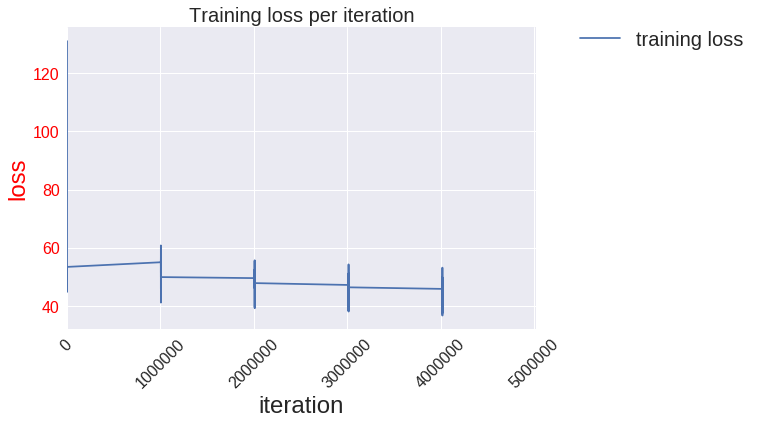

In [23]:
fig1, ax1 = plt.subplots()
fig1.set_size_inches(8, 6)
ax1.plot(log_train[0], log_train[1])
ax1.set_xlim(0, (n_epochs * train_size))
ax1.set_xlabel("iteration", size=24)
ax1.set_ylabel("loss", color="r", size=24)
for tlbl in ax1.get_yticklabels():
    tlbl.set_color("r")
    tlbl.set_size(16)
for tlbl in ax1.get_xticklabels():
    tlbl.set_size(16)
    tlbl.set_rotation(45)
plt.legend(['training loss'], bbox_to_anchor=(1.48, 1.05), framealpha=0, fontsize=20)
plt.title("Training loss per iteration", size=20)
plt.tight_layout()

# QUESTIONS:

For the questions which ask you to modify the code, please search for "Q1" or "Q2" in the code above for suggestions on where the modifications should be made.

****
    QUESTION 1 - evaluation using perplexity
    
                A. Compute perplexity and add this information to the train 
                   log file
                B. Compute perplixity over validation data and create a new log file
                
    As you can see, we use cross-entropy loss to measure the total loss during the training phase.
    Remind yourself what the relationship is between cross-entropy and perplexity.
    Is the model trained to minimize perplexity of the training data? 
****

****
    QUESTION 2 - modify architecture
    
                A. Define a new model using GRU instead of LSTM
                B. Train and compute loss and perplexity as done for model_baseline
                C. Compare the performance and training time between the GRU and LSTMs
****

****
    QUESTION 3 - capturing morphological rules
    
    One of the benefits of recurrent neural networks for LM is that they are capable of capturing long-range dependencies. A natural language phenomenon in which such dependencies occur is morphological agreement. If a language requires that certain elements of the sentence agree in a specific feature, the morphological variants expressing that feature have to be used. For example, English requires that verb and its subject agree for person. If the subject is a 3rd person singular noun, the verb has to be inflected for the 3rd person:
                    "He buys some tangerines" is ok while
                    "They buys some tangerines" is ungrammatical.
                
    In this task you will inspect model performance on three agreement phenomena in Polish. You will using the provided prompts as seeds for generation, and you'll check whether the model predicts the next character right. For each prompt only one character is right, i.e. the resulting word does not vialate agreement requirements. There are other characters which produce a valid word, but the agreement is not maintained. Which character is right is determined by the preceeding words.
                
    ***** Having inspected the Polish examples, create similar prompts for English (keep in mind that we're modelling Shakespeare's English, so you might want to take a look at the corpus before comming up with your prompts). Check whether your English models are more or less successful in predicting the right character than the Polish models. Try to think of possible reasons for any observed differences. *****
****

In [ ]:
'''
Q3
'''

if not English:
    polish_samples = ["Zosia ze wstążki kokardę zrobił", 
                      "bocian ma skrzydła biał",
                      "patrzyliśmy na piękną pann"]
    
    polish_right_answers = ['a', 'e', 'ę']
    
    polish_wrong_answers = [[' ', 'y', 'o'],
                            ['a', 'y', 'o'],
                            ['a', 'y', 'i', 'ą', 'o']]

    #s_ix = 1
    model_sample_results = []
    k = 10
    
    for i, s in enumerate(polish_samples):
        # Setting "sampling=False" disables random sampling from the softmax at the output
        # layer. Instead, we choose the most probable character
        # You should try both settings.
        model_sample_results.append(sample(list(polish_samples[i]), 1, 
                                           model_baseline, sampling=False))
        print("\n------------Sampled text-----------:\n{0:s}".format(model_sample_results[i][0]))
        if model_sample_results[i][0][-1] == polish_right_answers[i]:
            print("Correct (▀̿Ĺ̯▀̿ ̿)")
        elif model_sample_results[i][0][-1] in polish_wrong_answers[i]:
            print("In the ballpark ¯\_(ツ)_/¯")
        else:
            print("Incorrect ...  (ಥ﹏ಥ)")
        top_k_ixs = np.argpartition(model_sample_results[i][1], -k, axis=None)[-k:]
        top_k_probs = model_sample_results[i][1][np.argpartition(model_sample_results[i][1], 
                                                           -k, axis=None)[-k:]]

        print("{0:>5s} | {1:6s}".format("char", "prob"))
        print("\n".join(["{0:>5s} | {1:>.5f}".format(c if c!="\n" else "\\n", p) 
                        for c, p in sorted(zip([ix_to_char[ix] for ix in top_k_ixs], top_k_probs), 
                                           reverse=True, key=lambda t: t[1])]))

****
    EXTRA ACTIVITIES - what changes would help the model capture the structure of the data?
    
       The RNN LMs we trained for English generally do a good job learning the structure of
       Shakespeare's dramas. They pick op on the fact that lines of text come interspersed
       with character name followed by a colon. However, the rigid 13-syllables-per-line
       structure of the Polish epic poem is not captured. Come up with a hypothesis as to
       what changes to the model architecture could help it to learn that structure. You might
       consider the following:
                A. increasing batch size
                B. additional layers
                C. wider layers
       If you're so inclined, you might try implementing your changes and evaluating their
       effects.
****